# **Avalanche Risk Project**

Advanced Data Analytics, Fall 2025

The following project examines the feasibility of deep learning models (3D-CNN, convLSTM) compared to traditional, state-of-the-art methods for predicting avalanche danger levels. Using a comprehensive dataset from the Swiss Federal Institute for Snow and Avalanche Research (SLF) spanning from 1997-2020, the project heavily relies on the work of Pérez-Guillén et al. (2022) and Maissen et al. (2024) and adopts many of their preprocessing and modeling techniques.

In [1]:
import os
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import requests

## **4. Grid Data Preparation**

### **4.1 Spatial Grid**

First, I will get the DEM data for Switzerland and create a spatial grid with a resolution of 1km x 1km. This grid will be used to aggregate the various datasets (weather, snow, avalanche occurrences) to a common spatial resolution.

In [2]:
# Retrieve API key from .env file
load_dotenv()
API_KEY = os.getenv("OPENTOPO_API_KEY")
output_file = "../data/swiss_dem_srtm.tif"

In [3]:
# Covers entire Switzerland + border regions
bounds = {
    'minx': 5.9,  # West
    'miny': 45.8, # South
    'maxx': 10.6, # East
    'maxy': 47.9  # North
}

# URL for SRTM GL1 (30m resolution) - Best balance of detail/size
url = "https://portal.opentopography.org/API/globaldem"

params = {
    'demtype': 'SRTMGL1',  # 30m resolution
    'south': bounds['miny'],
    'north': bounds['maxy'],
    'west': bounds['minx'],
    'east': bounds['maxx'],
    'outputFormat': 'GTiff',
    'API_Key': API_KEY
}

print("Requesting single merged GeoTIFF from OpenTopography...")
response = requests.get(url, params=params, stream=True)

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"SUCCESS! Saved to: {output_file}")
else:
    print(f"Error: {response.status_code}")
    print(response.text)

Requesting single merged GeoTIFF from OpenTopography...


KeyboardInterrupt: 

CRS: EPSG:4326
Transform: | 0.00, 0.00, 5.90|
| 0.00,-0.00, 47.90|
| 0.00, 0.00, 1.00|
Width x Height: 16920 x 7560
Bounds: BoundingBox(left=5.899861111135749, bottom=45.800138888887005, right=10.599861111136372, top=47.900138888887284)
Profile keys: ['driver', 'dtype', 'nodata', 'width', 'height', 'count', 'crs', 'transform', 'blockxsize', 'blockysize', 'tiled', 'compress', 'interleave']


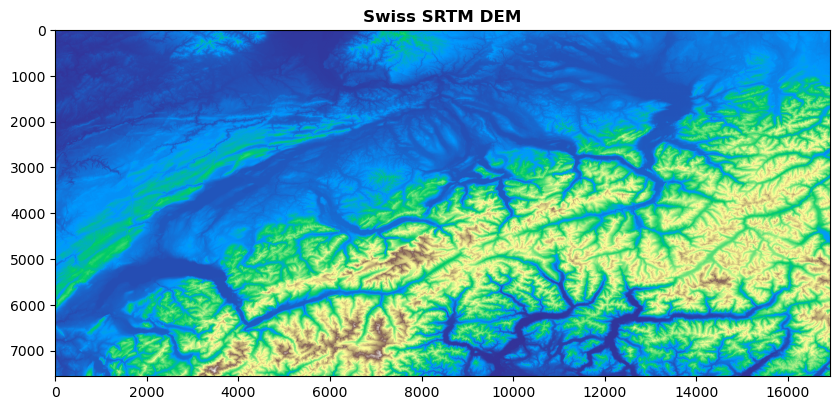

In [3]:
fn = "../data/swiss_dem_srtm.tif"

with rasterio.open(fn) as src:
    # basic metadata
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Width x Height:", src.width, "x", src.height)
    print("Bounds:", src.bounds)
    print("Profile keys:", list(src.profile.keys()))
    # read first band as a masked array (handles nodata)
    dem = src.read(1, masked=True)

# quick plot
plt.figure(figsize=(10, 8))
show(dem, cmap="terrain", title="Swiss SRTM DEM")
plt.show()

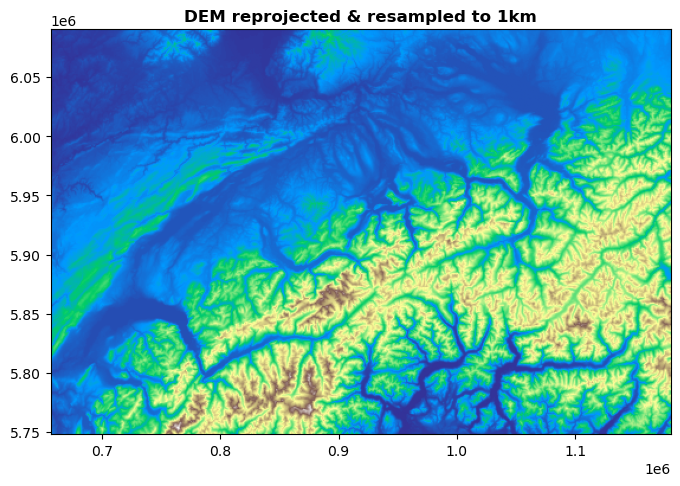

In [4]:
# ...existing code...
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = "EPSG:3857"          # metric CRS for 1km cells
dst_res = 1000                # target resolution in meters

with rasterio.open(fn) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=dst_res
    )
    profile = src.profile.copy()
    profile.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "dtype": "float32"
    })

    dst = np.empty((height, width), dtype="float32")
    reproject(
        source=src.read(1),
        destination=dst,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.average
    )

plt.figure(figsize=(8, 6))
show(dst, transform=transform, cmap="terrain", title="DEM reprojected & resampled to 1km")
plt.show()
# ...existing code...

In [5]:
from scipy.interpolate import griddata

def create_daily_grid(day_df, grid_coords, feature_list):
    # points = (station_lon, station_lat) from the input dataframe
    points = day_df[['lon', 'lat']].values 
    
    daily_channels = []
    
    for feat in feature_list:
        values = day_df[feat].values
        
        # Linear Interpolation onto the target grid (grid_coords)
        grid = griddata(points, values, grid_coords, method='linear')
        
        # Fill any remaining NaNs (edges) using the nearest neighbor method
        nan_mask = np.isnan(grid)
        if nan_mask.any():
            grid[nan_mask] = griddata(points, values, grid_coords[nan_mask], method='nearest')
            
        daily_channels.append(grid)
        
    # Resulting shape: (Height, Width, Channels)
    return np.stack(daily_channels, axis=-1)